# Customer Bike Share Model

**Import pacakges**

In [159]:
import warnings
warnings.filterwarnings('ignore')

In [160]:
import pandas.io.data as web
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
import math
import statsmodels as sm
import seaborn as sns
import pylab
import pprint
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smgraph
import scipy.stats as stats

from pandas.tools.plotting import scatter_matrix
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.cross_validation import train_test_split, cross_val_score

from sklearn import metrics

%matplotlib inline
sns.set_palette("Set2", 10) #Set color scheme
sns.set_style("darkgrid") #Set style for axis
pd.set_option('display.max_rows', 500)

In [161]:
#Import data files
bike_df = pd.read_csv('bike_combined.csv')
model_df = bike_df.copy()

In [162]:
#Create weekday/weekend dummy
model_df.Date = pd.to_datetime(model_df.Date)
model_df['Weekday'] = model_df.Date.dt.weekday_name
week_dummy = pd.get_dummies(model_df.Weekday)
model_df = pd.concat([model_df, week_dummy], axis = 1)
model_df.drop(['Weekday'], axis = 1, inplace = True)

#Season dummy
season_dummy = pd.get_dummies(model_df.Season_Name)
model_df = pd.concat([model_df, season_dummy], axis = 1)
model_df.drop(['Season_Name'], axis = 1, inplace = True)

#Dummy for City
model_df.City = model_df.City.replace({'DC': 1, 'Chicago': 0})

#Drop NaN rows
model_df = model_df.dropna(how = 'any')

#Replace T value
model_df = model_df.replace({'T' : 0}, regex = True)

#Outlier adjust
# model_df = model_df[model_df.Customer_sum > 3000]

# Data Set Decriptive Stats

In [163]:
model_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_sum,2207.0,2200.065700,2248.168768,2.000000,499.500000,1643.000000,3030.500000,18280.000000
Subscriber_sum,2207.0,6355.984594,3192.462047,52.000000,3805.500000,6666.000000,8756.000000,14268.000000
Total_Count sum,2207.0,8556.050295,4509.411632,56.000000,4805.000000,8930.000000,11713.000000,24989.000000
Season,2207.0,2.630267,1.076473,1.000000,2.000000,3.000000,4.000000,4.000000
Holiday,2207.0,0.027639,0.163974,0.000000,0.000000,0.000000,0.000000,1.000000
Duration_mean,2207.0,16.040797,4.760595,8.871921,12.404918,15.288303,18.078578,41.802399
DAILYAverageDryBulbTemp,2207.0,57.221568,19.551785,-9.000000,44.000000,60.000000,74.000000,91.000000
DAILYDeptFromNormalAverageTemp,2207.0,0.834708,8.016329,-32.900000,-3.800000,1.200000,6.000000,28.900000
DAILYAverageRelativeHumidity,2207.0,64.762121,13.211236,28.000000,56.000000,65.000000,74.000000,98.000000
DAILYCoolingDegreeDays,2207.0,4.362483,6.340591,0.000000,0.000000,0.000000,9.000000,26.000000


In [164]:
#Create log variable
model_df['log_customer'] = np.log(model_df.Customer_sum)

#Create dependent variable
y = model_df.log_customer

#Create independent variables
X = model_df.ix[:,'Season': 'Wednesday']

#Variables to drop
X.drop(['DAILYAverageStationPressure', 'DAILYDeptFromNormalAverageTemp', 'DAILYSnowDepth', 'DAILYSustainedWindDirection'], axis = 1, inplace = True)

# Dependent Variable Distributions

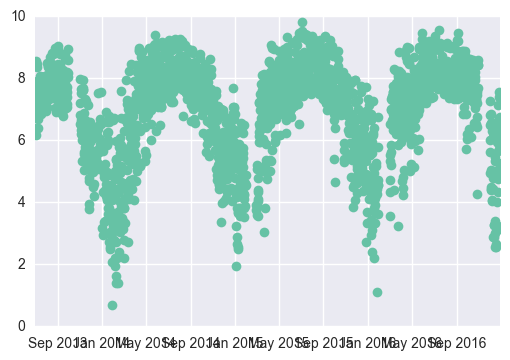

In [165]:
#Count over time
plt.plot_date(model_df.Date, model_df.log_customer, xdate = True)

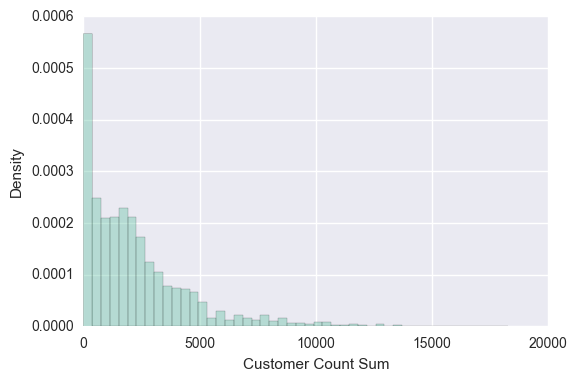

In [166]:
#Dependent distributions
ax = sns.distplot(model_df.Customer_sum, kde = False, rug = False, norm_hist = True)
plt.xlabel('Customer Count Sum')
ax.set_ylabel('Density')
plt.show()

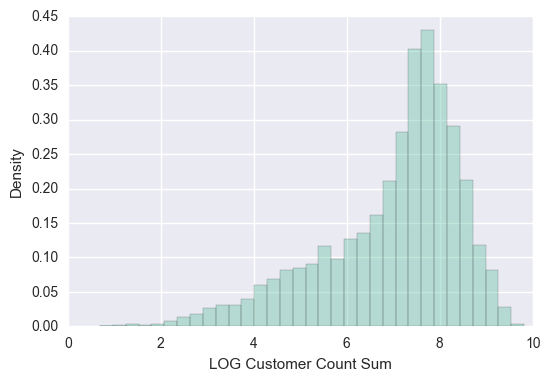

In [167]:
#Log distributions
ax = sns.distplot(y, kde = False, rug = False, norm_hist = True)
plt.xlabel('LOG Customer Count Sum')
ax.set_ylabel('Density')
plt.show()

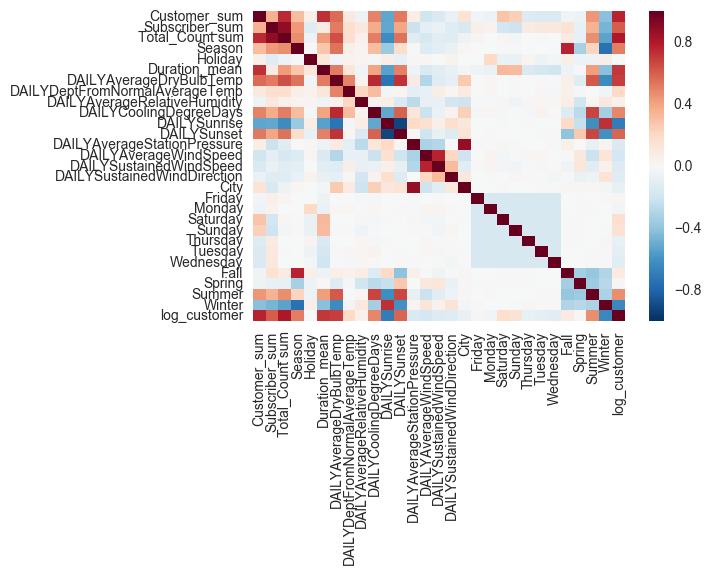

In [168]:
#Correlation Heatmap
corr = model_df.corr()
sns.heatmap(corr)

In [169]:
#Correlation Values List
s = corr.unstack()
so = s.order(kind = 'quicksort')
pp = pprint.PrettyPrinter()
pp.pprint(so)

#Dropped (Based on correlation and heatmap): 
# DAILYMaximumDryBulbTemp DAILYMinimumDryBulbTemp (Kept average)
# DAILYAverageSeaLevelPressure (Lower corr to dependent since redundant)
# DAILYPeakWindSpeed PeakWindDirection (Kept Average)
# DAILYAverageDewPointTemp DAILYAverageWetBulbTemp (Lower corr to dependent since redundant)

DAILYSunrise                    DAILYSunset                      -0.920910
DAILYSunset                     DAILYSunrise                     -0.920910
Season                          Winter                           -0.749454
Winter                          Season                           -0.749454
DAILYSunrise                    DAILYAverageDryBulbTemp          -0.730612
DAILYAverageDryBulbTemp         DAILYSunrise                     -0.730612
DAILYSunrise                    log_customer                     -0.698576
log_customer                    DAILYSunrise                     -0.698576
                                Winter                           -0.647764
Winter                          log_customer                     -0.647764
DAILYAverageDryBulbTemp         Winter                           -0.638198
Winter                          DAILYAverageDryBulbTemp          -0.638198
Total_Count sum                 DAILYSunrise                     -0.631289
DAILYSunrise             

# Categorical Boxplots

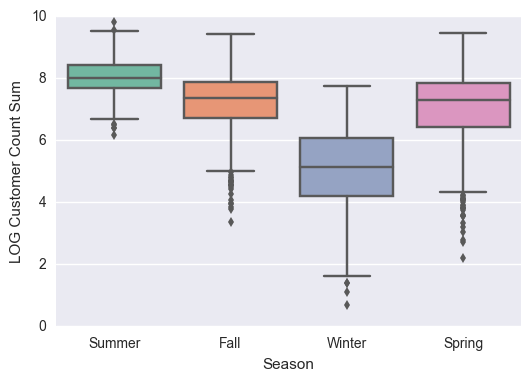

In [170]:
seasons_df = model_df[['log_customer', 'Season']]
#Log Season Boxplots
ax = sns.boxplot(y, groupby = bike_df.Season_Name)
ax.set_ylabel('LOG Customer Count Sum')
plt.xlabel('Season')
plt.show()

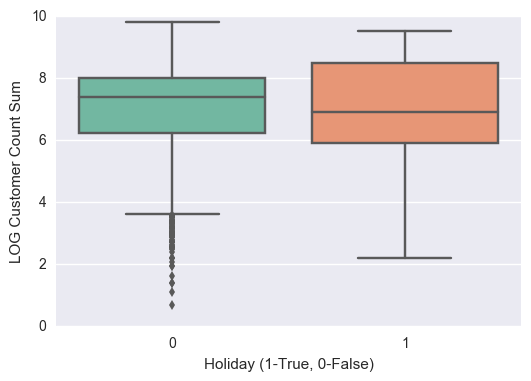

In [171]:
#Log Holiday Boxplots
ax = sns.boxplot(y, groupby = model_df.Holiday)
ax.set_ylabel('LOG Customer Count Sum')
plt.xlabel('Holiday (1-True, 0-False)')
plt.show()

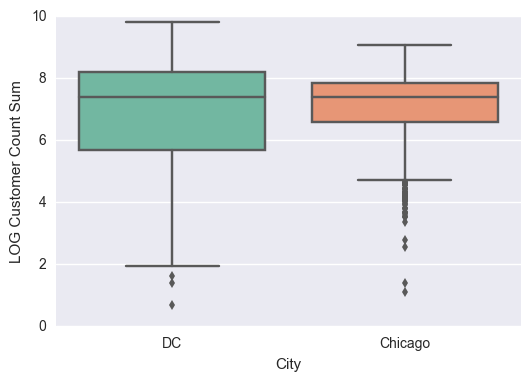

In [172]:
#Log City Boxplots
ax = sns.boxplot(y, groupby = bike_df.City)
ax.set_ylabel('LOG Customer Count Sum')
plt.show()

# Training and Test Sets

In [173]:
#Create training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7777)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1765, 18)
(1765,)
(442, 18)
(442,)


# Log-Linear Regression Model

In [174]:
#Linear Regression Model
lm = smf.OLS(y_train.astype(float), X_train.astype(float))
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_customer   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     279.6
Date:                Sat, 03 Jun 2017   Prob (F-statistic):               0.00
Time:                        15:49:06   Log-Likelihood:                -2043.6
No. Observations:                1765   AIC:                             4123.
Df Residuals:                    1747   BIC:                             4222.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Season                           0.1498      0.027      5.651      0.000         0.098     0.202
Holiday                         -0.2349      0.123     -1.916      0.055        -0.475     0.006
Duration_mean                    0.1094      0.007     16.801      0.000         0.097     0.122
DAILYAverageDryBulbTemp          0.0198      0.002      8.424      0.000         0.015     0.024
DAILYAverageRelativeHumidity     0.0045      0.002      2.966      0.003         0.002     0.007
DAILYCoolingDegreeDays           0.0100      0.005      2.104      0.036         0.001     0.019
DAILYSunrise                    -0.0080      0.001     -9.263      0.000        -0.010    -0.006
DAILYSunset                     -0.0042      0.001     -5.477      0.000        -0.006    -0.003
DAILYAverageWindSpeed            0.0206      0.009      2.303      0.021         0.003     0.038
DAILYSustainedWindSpeed         -0.0178      0.005     -3.718      0.000        -0.027    -0.008
City                            -0.1035      0.060     -1.733      0.083        -0.221     0.014
Friday                          15.7936      1.893      8.343      0.000        12.081    19.506
Monday                          15.6317      1.893      8.258      0.000        11.919    19.344
Saturday                        15.8712      1.895      8.377      0.000        12.155    19.587
Sunday                          15.8148      1.894      8.350      0.000        12.100    19.530
Thursday                        15.5522      1.895      8.209      0.000        11.836    19.268
Tuesday                         15.5357      1.893      8.208      0.000        11.823    19.248
Wednesday                       15.4984      1.892      8.193      0.000        11.788    19.209
==============================================================================
Omnibus:                      331.629   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              840.527
Skew:                          -1.010   Prob(JB):                    3.03e-183
Kurtosis:                       5.711   Cond. No.                     5.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Residual Analysis

In [175]:
#Calculate residuals
predicted = results.fittedvalues
res = y_train - predicted

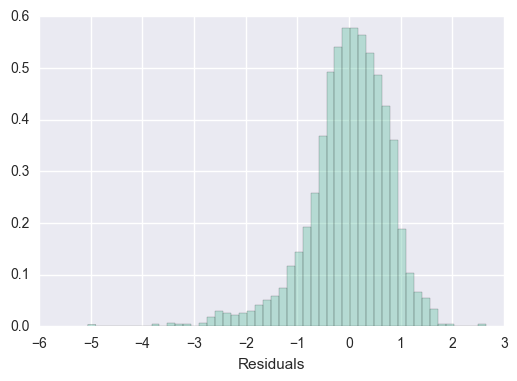

In [176]:
#Residual distribution
ax = sns.distplot(res, kde = False, rug = False, norm_hist = True)
plt.xlabel('Residuals')
plt.show()

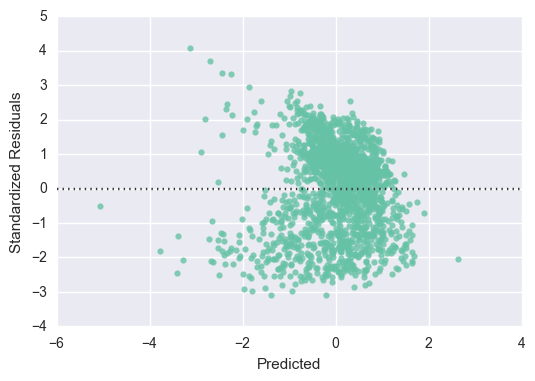

In [177]:
#Normal Residuals Plot
ax = sns.residplot(res, predicted)
plt.xlabel('Predicted')
ax.set_ylabel('Standardized Residuals')
plt.show()

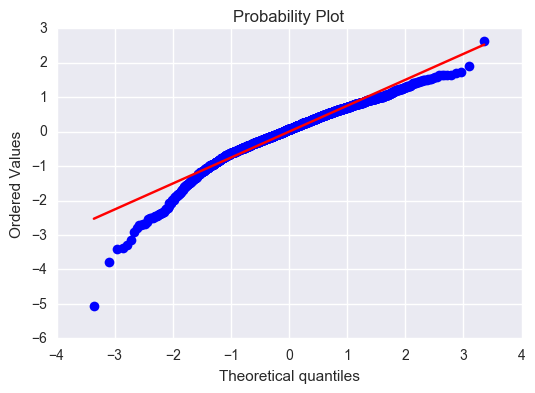

In [178]:
#Probability Plot
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(res, dist="norm", plot=pylab)
pylab.show()

# Predictions

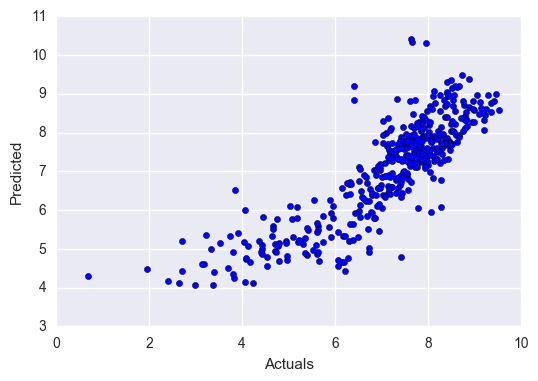

In [179]:
#Prediction on test set, plot predicted vs. actuals
preds = results.predict(X_test.astype(float))
plt.scatter(y_test, preds)
plt.xlabel('Actuals')
plt.ylabel('Predicted')